In [1]:
!pip install --upgrade scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.6/dist-packages (0.24.1)


In [2]:
!git clone https://github.com/DevoLearn/devolearn.git

fatal: destination path 'devolearn' already exists and is not an empty directory.


In [3]:
!cp /content/drive/MyDrive/mydata/epic_subsets/epic_10k.csv /content/
!cp /content/drive/MyDrive/mydata/epic_subsets/scaled_epic_10k.csv /content/
!cp /content/drive/"My Drive"/frames_raw.zip /content/
!unzip frames_raw.zip

Archive:  frames_raw.zip
replace frames/20070306_pha4_I2L_3/174.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [4]:
!cp /content/drive/MyDrive/models/lineage_pop_res_50/10k_res_18_identical_2.pth /content/

In [5]:
import torch
import torchvision.models as models
import torch.nn as nn
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torchvision.transforms as transforms
from PIL import Image
import numpy as np

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [18]:
model_dummy = models.resnet18(pretrained = True)
model_1 = models.resnet18(pretrained = True)
model_2 = models.resnet18(pretrained = True)
model_1.fc = model_1.fc = nn.Linear(512, 7)
model_2.fc = model_2.fc = nn.Linear(512, 7)
model_dummy.fc = model_dummy.fc = nn.Linear(512, 7)



model_1 = model_1.to(device)
model_2 = model_2.to(device)
model_dummy=model_dummy.to(device)

In [ ]:
model_1.load_state_dict(torch.load("/content/devolearn/devolearn/lineage_population_model/estimate_lineage_population.pt"))
scaler_1 = joblib.load("/content/devolearn/devolearn/lineage_population_model/scaler/scaler.gz")

model_2.load_state_dict(torch.load("/content/10k_res_18_identical_2.pth"))
scaler_2 = joblib.load("/content/scaler_new_10k.gz")

model_1.eval()
model_2.eval()

In [39]:
print("Minimun values of each column (devolearn) = ", scaler_1.data_min_)
print("Maximum values of each column (devolearn) = ", scaler_1.data_max_)
print("Minimun values of each column (new) = ", scaler_2.data_min_)
print("Maximum values of each column (new) = ", scaler_2.data_max_)

#make alpha bar plot

Minimun values of each column (devolearn) =  [0. 0. 0. 0. 0. 0. 0.]
Maximum values of each column (devolearn) =  [250.  14.  43.   1.  26.   8.   2.]
Minimun values of each column (new) =  [0. 0. 0. 0. 0. 0. 0.]
Maximum values of each column (new) =  [250.  16.  78.   1.  31.  16.   2.]


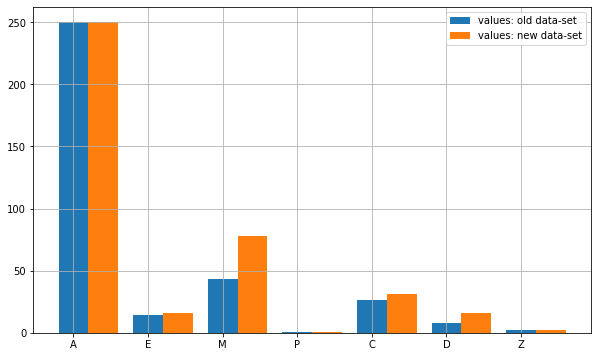

In [63]:
plt.rcParams['figure.figsize'] =10, 6
width = 0.40
labels=['A','E','M', 'P', 'C', "D", "Z"]
ind = np.arange(7)
plt.bar(ind, scaler_1.data_max_, width, label="values: old data-set")
plt.bar(ind+width, scaler_2.data_max_, width,  label="values: new data-set")
plt.xticks(ind, labels)
plt.grid()
plt.legend(loc='best')
plt.show()

In [21]:
mini_transform = transforms.Compose([
                                     transforms.ToPILImage(),
                                     transforms.Resize((256,256), interpolation = Image.NEAREST),
                                     transforms.ToTensor(),
                                     transforms.Normalize(0.5, 0.5, 0.5)
])

In [22]:
def researcher_vs_model(look_for_tag, model_, scaler_):
    df_test = pd.read_csv("scaled_epic_10k.csv")
    df_single_cell = df_test[df_test['filenames'].str.contains(look_for_tag)]
    a_pop_upper_limit = 250
    df_test = df_test[df_test["A"] <= a_pop_upper_limit]
    data = scaler_.inverse_transform(df_single_cell[['A', 'E', 'M', 'P', 'C', 'D', 'Z']].values)
    real_time_plots = []
    
    for i in range(len(df_single_cell.columns[1:])):
        real_time_plots.append(data[:,i])

    preds = []
    filenames = df_single_cell.filenames.values

    for i in range (len(filenames)):
        image = cv2.imread(filenames[i])
        tensor = mini_transform(image).unsqueeze(0).to(device)
        pred = model_(tensor).cpu().detach().numpy().flatten()
        preds.append(pred)
        
    preds = scaler_.inverse_transform(np.array(preds)).astype(np.uint8)

    generated_time_plots = []
    for i in range(len(df_single_cell.columns[1:])):
        generated_time_plots.append(preds[:,i])

    plt.rcParams['figure.figsize'] =25, 10

    for i in range(len(real_time_plots)):
        plt.plot(real_time_plots[i], label = df_single_cell.columns[:-1][i] )

    for i in range(len(generated_time_plots)):
        plt.plot(generated_time_plots[i], label = df_single_cell.columns[:-1][i] + "_pred", linestyle = "--", linewidth = 2 )

    plt.xlabel("time", fontsize = 25)
    plt.ylabel("population", fontsize = 25)
    plt.legend(fontsize = 20)
    plt.grid()
    plt.show()

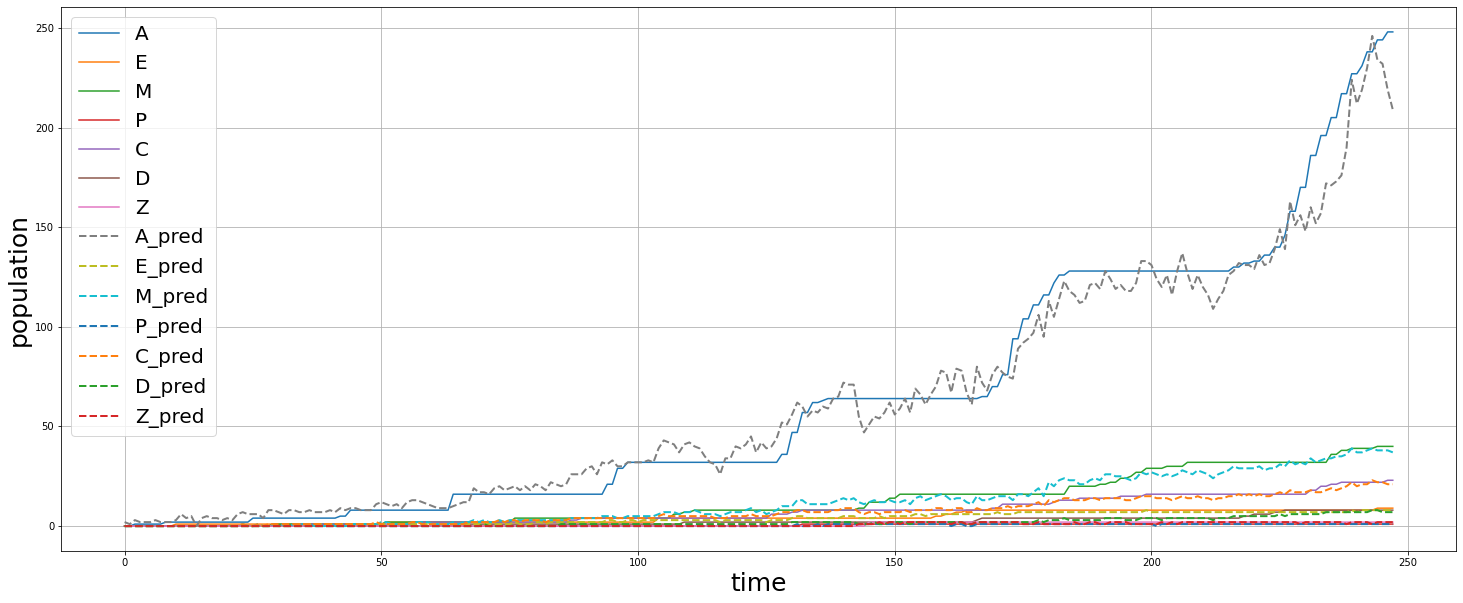

20080709_ceh-27_1_L1


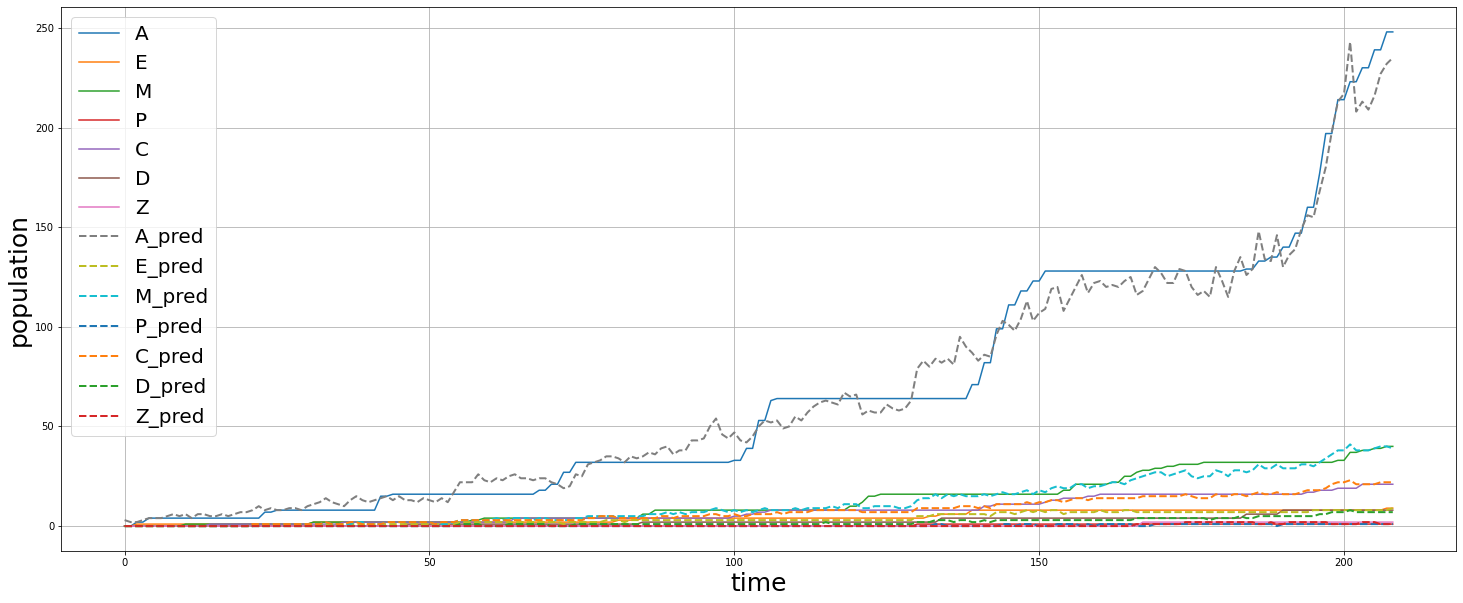

20080731_ceh-32_4_L1


In [23]:
clean_tags = [
             "20080709_ceh-27_1_L1",
              "20080731_ceh-32_4_L1",
              ]

for tag in clean_tags:
  researcher_vs_model(look_for_tag=tag, 
                      model_ = model_2, 
                      scaler_=scaler_2)
  print(tag)


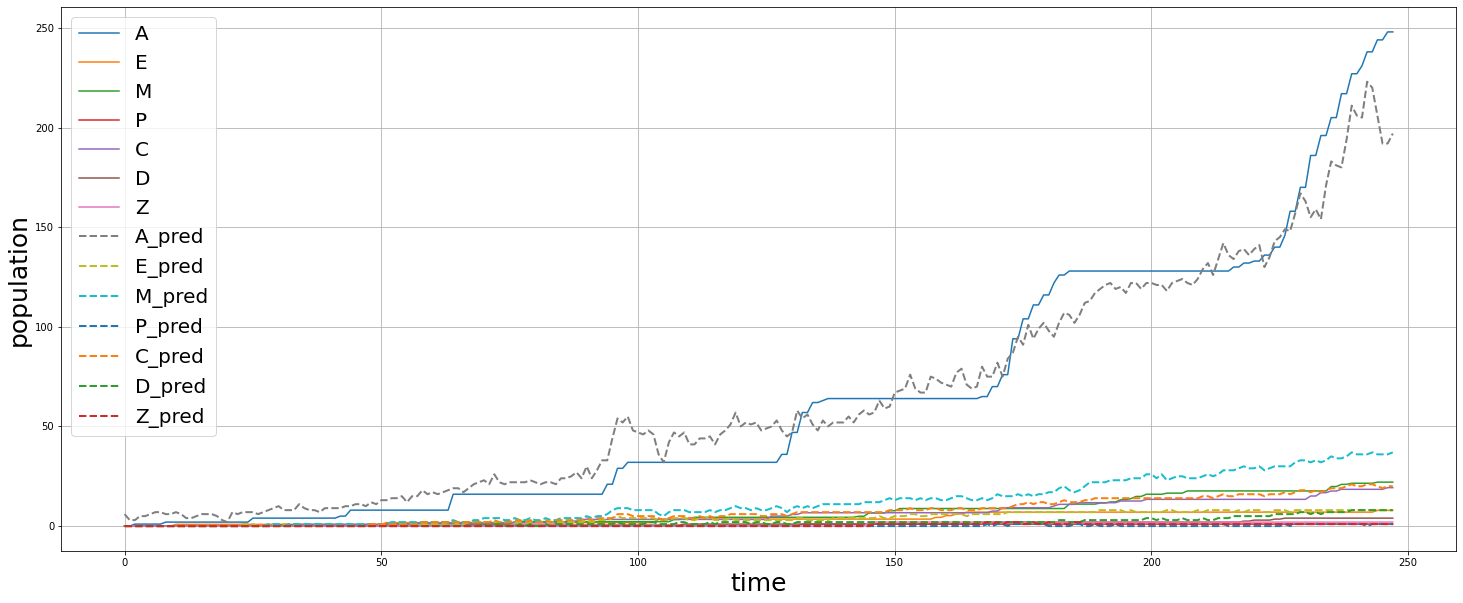

20080709_ceh-27_1_L1


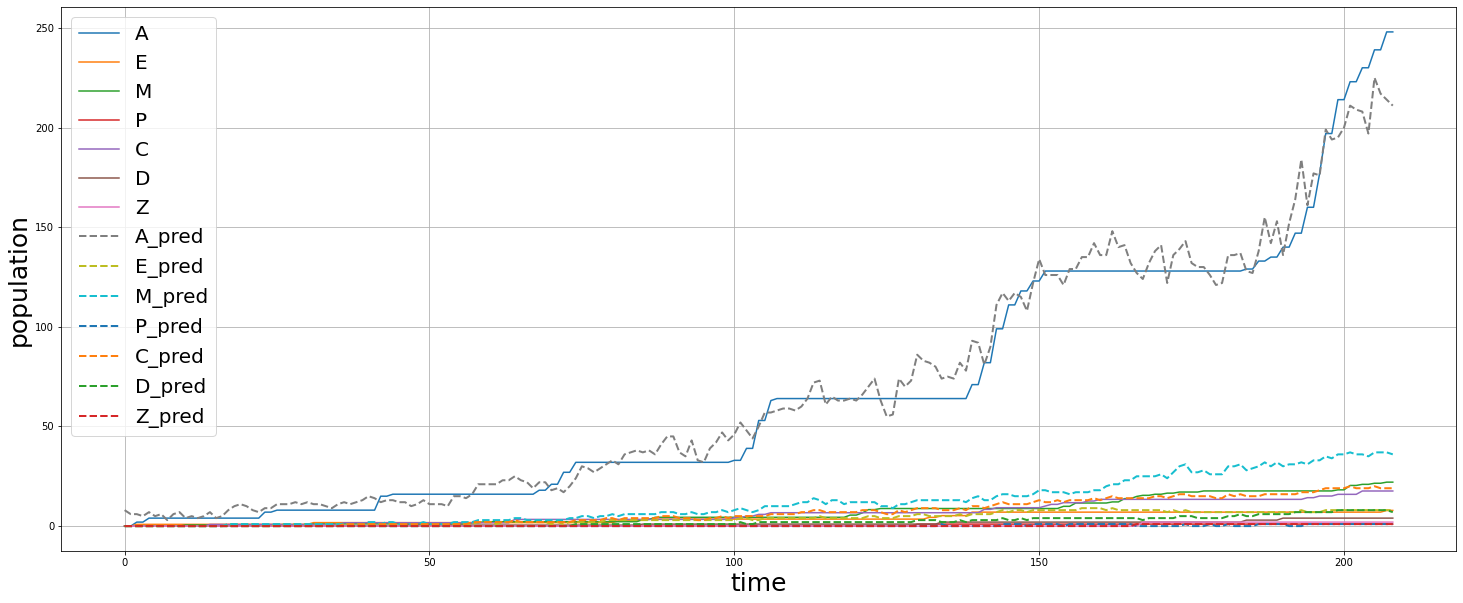

20080731_ceh-32_4_L1


In [24]:
for tag in clean_tags:
  researcher_vs_model(look_for_tag=tag, 
                      model_ = model_1, 
                      scaler_=scaler_1)
  print(tag)


In [25]:
from sklearn.metrics import mean_squared_error

In [37]:
def compute_loss(look_for_tag, model_, scaler_):
  df_test = pd.read_csv("scaled_epic_10k.csv")
  df_single_cell = df_test[df_test['filenames'].str.contains(look_for_tag)]
  a_pop_upper_limit = 250
  df_test = df_test[df_test["A"] <= a_pop_upper_limit]
  data = scaler_.inverse_transform(df_single_cell[['A', 'E', 'M', 'P', 'C', 'D', 'Z']].values)
  real_time_plots = []
  
  for i in range(len(df_single_cell.columns[1:])):
      real_time_plots.append(data[:,i])

  preds = []
  filenames = df_single_cell.filenames.values

  for i in range (len(filenames)):
      image = cv2.imread(filenames[i])
      tensor = mini_transform(image).unsqueeze(0).to(device)
      pred = model_(tensor).cpu().detach().numpy().flatten()
      preds.append(pred)
      
  preds = scaler_.inverse_transform(np.array(preds)).astype(np.uint8)
  generated_time_plots = []
  
  for i in range(len(df_single_cell.columns[1:])):
      generated_time_plots.append(preds[:,i])

  loss = mean_squared_error(real_time_plots,generated_time_plots)
  return(loss)

In [38]:
for tag in clean_tags:
  print("loss in video id: "+tag+" =", compute_loss(look_for_tag=tag, 
                                               model_=model_1, 
                                               scaler_=scaler_1))

loss in video id: 20080709_ceh-27_1_L1 = 31.40345772812858
loss in video id: 20080731_ceh-32_4_L1 = 20.759797680362603


In [36]:
for tag in clean_tags:
  print("loss in video id: "+tag+" =", compute_loss(look_for_tag=tag, 
                                               model_=model_2, 
                                               scaler_=scaler_2))

loss in video id: 20080709_ceh-27_1_L1 = 14.885944700460831
loss in video id: 20080731_ceh-32_4_L1 = 12.4025974025974


In [28]:
#to do: bar graph accross n videos